In [ ]:
import sys
import math
from google.colab import drive
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from collections import defaultdict
import pickle
from tqdm import tqdm
from statistics import *
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
!pip install arch
from arch import arch_model
import scipy.stats as stats

drive.mount('/content/drive', force_remount=True)
colab_path="/content/drive/Shareddrives/CS2952Q - Final Project (Volatility Models)/Final Data"
sys.path.append(colab_path)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 4.9 MB/s eta 0:00:00
Mounted at /content/drive


# Data Processing

In [ ]:
def get_sp500_tickers():
    # Return a Name List of Length 503
    # Wikipedia page of S&P 500 companies, which includes their tickers
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

    # Send a GET request
    response = requests.get(url)

    # Read the HTML table into a list of DataFrame objects
    sp500_list = pd.read_html(response.text)
    tickers_df = sp500_list[0]
    tickers = tickers_df['Symbol'].tolist()
    tickers = [ticker.replace('.', '-') for ticker in tickers]
    return tickers

In [ ]:
sp500_tickers = get_sp500_tickers()
time_period = "20y"

In [ ]:
# data = yf.download(sp500_tickers, period=time_period, group_by='ticker')
# print(data.shape)
# data.head(10)

In [ ]:
# stock_group = "sp500"
# all_stocks = pd.DataFrame()
# for ticker in sp500_tickers:
#     # Get the individual ticker data
#     ticker_data = data[ticker].dropna(how='all')

#     # Insert the 'Ticker' column
#     ticker_data['Ticker'] = ticker

#     # Ensure the 'Date' column is present if it's not in the index
#     if 'Date' not in ticker_data.columns:
#         ticker_data.reset_index(level=0, inplace=True)

#     # Append this data to the main DataFrame
#     all_stocks = pd.concat([all_stocks, ticker_data], ignore_index=True)

# # Show the DataFrame
# print(all_stocks.shape)
# all_stocks.to_pickle(f"{colab_path}/{stock_group}_{time_period}.pkl")


In [ ]:
# all_stocks.head()

In [ ]:
stock_group = "sp500"
time_periods = ["10y", "20y", "all"]
for time_period in time_periods:
  all_stocks = pd.read_pickle(f"{colab_path}/{stock_group}_{time_period}.pkl")
  all_stocks['Prev Adj Close'] = all_stocks.groupby('Ticker')['Adj Close'].shift(1)
  all_stocks['Prev Close'] = all_stocks.groupby('Ticker')['Close'].shift(1)
  all_stocks['Daily Return'] = all_stocks.groupby('Ticker')['Adj Close'].pct_change()
  all_stocks['Log Return'] = np.log(all_stocks['Adj Close'] / all_stocks['Prev Adj Close'])
  all_stocks = all_stocks.dropna(subset=['Prev Adj Close', 'Prev Close'])
  all_stocks.dropna(inplace=True)
  all_stocks.to_pickle(f"{colab_path}/{stock_group}_{time_period}.pkl")


In [ ]:
stock_group = "sp500"
time_period = "20y"
all_stocks = pd.read_pickle(f"{colab_path}/{stock_group}_{time_period}.pkl")

# Simple Data Analysis

In [ ]:
# stock_group = "sp500"
# time_period = "20y"
# all_stocks = pd.read_pickle(f"{colab_path}/{stock_group}_{time_period}.pkl")
# all_stocks.head()
# # Load in the different volatility metrics
# all_stocks['Naive Vol'] = abs(all_stocks['Log Return'])

# all_stocks['Parkinson Vol'] = np.sqrt((1 / (4 * np.log(2))) * np.log(all_stocks['High'] / all_stocks['Low'])**2)
# all_stocks['Garman-Klass Vol'] = all_stocks.apply(calculate_garman_klass_volatility, axis=1)

# # all_stocks['RS_Temp H-C'] = np.log(all_stocks['High'] / all_stocks['Close'])
# # all_stocks['RS_Temp H-O'] = np.log(all_stocks['High'] / all_stocks['Open'])
# # all_stocks['RS_Temp H'] = all_stocks['RS_Temp H-C'] * all_stocks['RS_Temp H-O']
# # all_stocks['RS_Temp L-C'] = np.log(all_stocks['Low'] / all_stocks['Close'])
# # all_stocks['RS_Temp L-O'] = np.log(all_stocks['Low'] / all_stocks['Open'])
# # all_stocks['RS_Temp L'] = all_stocks['RS_Temp L-C'] * all_stocks['RS_Temp L-O']
# # all_stocks['RS_Temp'] = all_stocks['RS_Temp H'] + all_stocks['RS_Temp L']
# # negative_sqrt_rows = all_stocks[all_stocks['RS_Temp'] < 0]
# # print(negative_sqrt_rows)
# # print(negative_sqrt_rows['Ticker'])
# # del all_stocks['RS_Temp H-C']
# # del all_stocks['RS_Temp H-O']
# # del all_stocks['RS_Temp H']
# # del all_stocks['RS_Temp L-C']
# # del all_stocks['RS_Temp L-O']
# # del all_stocks['RS_Temp L']
# # del all_stocks['RS_Temp']


# all_stocks['Roger-Satchell Vol'] = all_stocks.apply(calculate_rogers_satchell_volatility, axis=1)

# k = 1 / 3
# all_stocks['Yang-Zhang Vol'] = np.sqrt(
#       (np.log(all_stocks['Open'] / all_stocks['Prev Close']) - np.mean(np.log(all_stocks['Open'] / all_stocks['Prev Close'])))**2 +
#       k * (np.log(all_stocks['Close'] / all_stocks['Open']) - np.mean(np.log(all_stocks['Close'] / all_stocks['Open'])))**2 +
#       (1 - k) * all_stocks['Roger-Satchell Vol']
# )

# all_stocks.to_pickle(f"{colab_path}/{stock_group}_{time_period}.pkl")
# all_stocks

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Daily Return,Log Return,Parkinson Vol,Naive Vol,Garman-Klass Vol,Roger-Satchell Vol,Yang-Zhang Vol,Prev Adj Close,Prev Close
4,2003-11-07,79.650002,79.889999,78.860001,79.040001,45.011929,2107900.0,MMM,-0.007035,-0.007059,0.007793,0.007059,0.009932,0.007410,0.070432,45.330811,79.599998
5,2003-11-10,79.040001,79.250000,78.650002,78.839996,44.898003,1740400.0,MMM,-0.002531,-0.002534,0.004564,0.002534,0.006260,0.005069,0.058155,45.011929,79.040001
6,2003-11-11,78.849998,78.970001,78.209999,78.500000,44.704384,2248000.0,MMM,-0.004312,-0.004322,0.005808,0.004322,0.007734,0.006264,0.064678,44.898003,78.839996
7,2003-11-12,78.500000,78.989998,78.059998,78.900002,44.932171,2035800.0,MMM,0.005095,0.005082,0.007113,0.005082,0.009550,0.008201,0.073997,44.704384,78.500000
8,2003-11-13,78.779999,79.739998,78.389999,79.650002,45.359295,1929300.0,MMM,0.009506,0.009461,0.010255,0.009461,0.012795,0.009634,0.080403,44.932171,78.900002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322657,2023-10-27,157.929993,157.929993,155.160004,156.029999,155.657318,2407100.0,ZTS,-0.012906,-0.012990,0.010627,0.012990,0.013010,0.009947,0.081746,157.692444,158.070007
2322658,2023-10-30,157.130005,158.410004,153.520004,157.000000,156.625000,2756200.0,ZTS,0.006217,0.006198,0.018831,0.006198,0.026626,0.024362,0.127626,155.657318,156.029999
2322659,2023-10-31,157.509995,158.529999,156.089996,157.000000,157.000000,3208900.0,ZTS,0.002394,0.002391,0.009315,0.002391,0.013019,0.010735,0.084675,156.625000,157.000000
2322660,2023-11-01,156.419998,157.000000,151.029999,151.440002,151.440002,7269900.0,ZTS,-0.035414,-0.036056,0.023282,0.036056,0.026071,0.015117,0.102202,157.000000,157.000000


<Axes: xlabel='Date', ylabel='Count'>

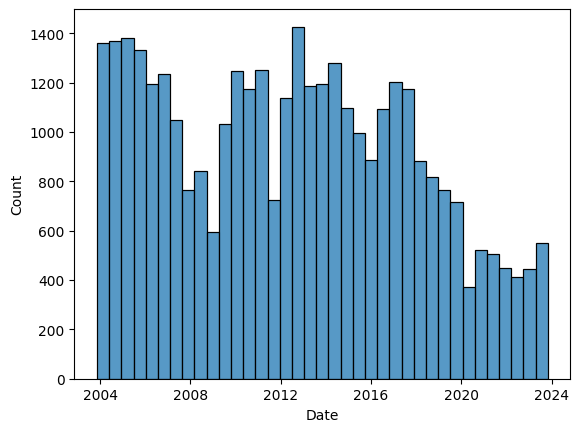

In [ ]:
all_stocks['Next Log Return'] = all_stocks.groupby('Ticker')['Log Return'].shift(-1)
sns.histplot(data = all_stocks[(all_stocks['Log Return'] == 0) | (all_stocks['Next Log Return'] == 0)],
             x = 'Date')

## Analyzing Bias

### Data Quantity Bias

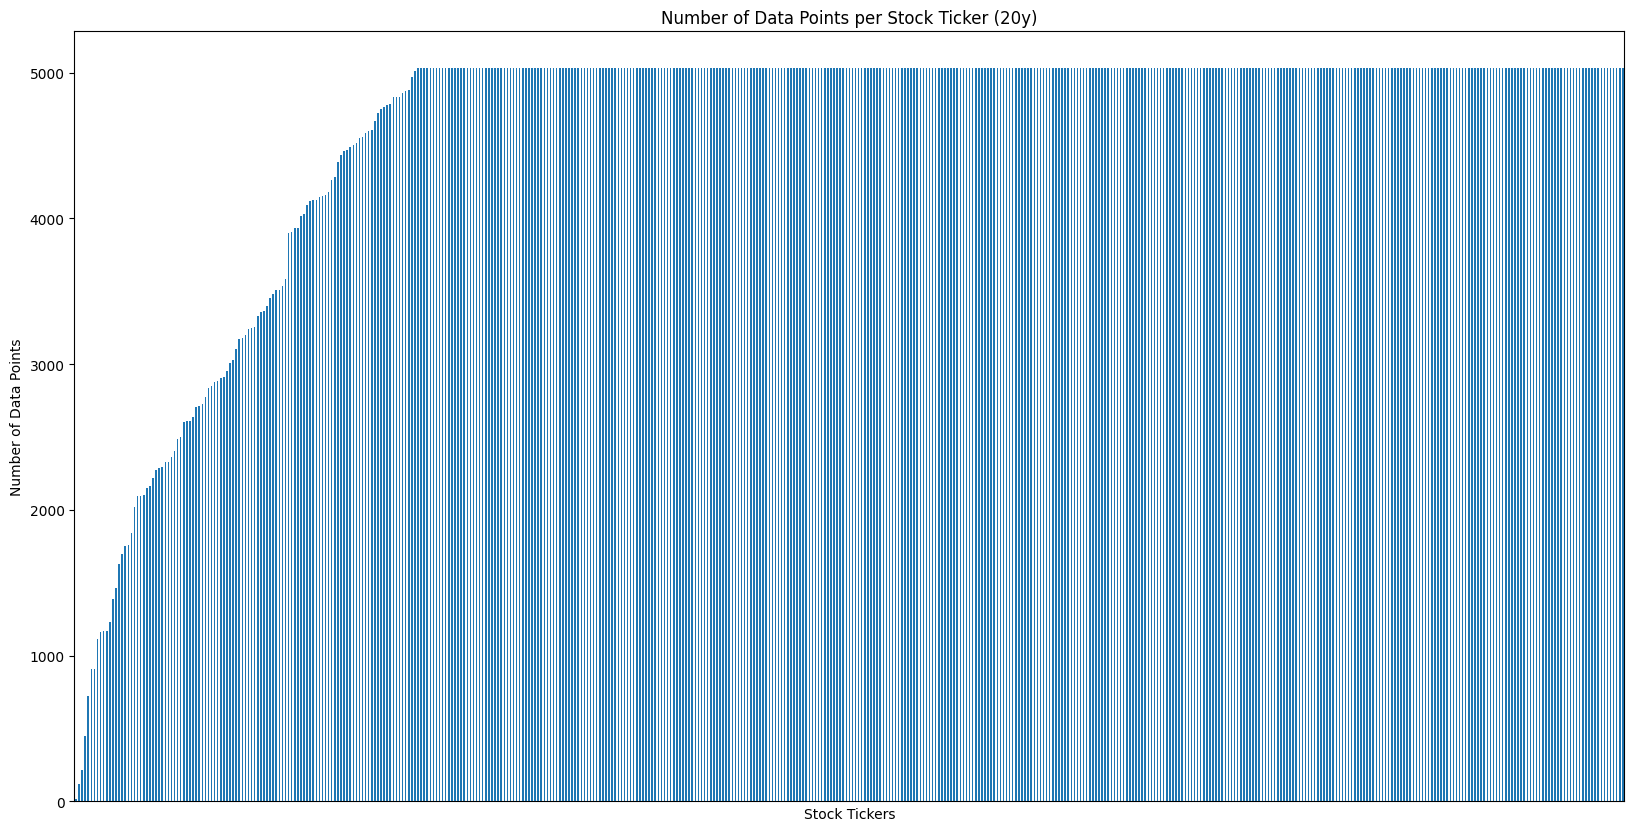

In [ ]:
row_counts = all_stocks['Ticker'].value_counts().sort_values()

# Plotting the sorted bar graph
plt.figure(figsize=(20, 10))
row_counts.plot(kind='bar')
plt.title(f'Number of Data Points per Stock Ticker ({time_period})')
plt.xlabel('Stock Tickers')
plt.ylabel('Number of Data Points')
plt.xticks([])
plt.show()

In [ ]:
# Interesting idea is to see if stocks with low data are still robust in whatever models we choose
max_row_count = max(all_stocks['Ticker'].value_counts())
low_data_tickers = list(row_counts[row_counts < max_row_count].sort_values().items())
print(f"Low Data Tickers: \n{low_data_tickers}")

Low Data Tickers: 
[('VLTO', 18), ('KVUE', 123), ('GEHC', 218), ('CEG', 447), ('ABNB', 725), ('CARR', 910), ('OTIS', 910), ('CTVA', 1116), ('DOW', 1162), ('FOX', 1167), ('FOXA', 1168), ('MRNA', 1231), ('CDAY', 1387), ('VICI', 1466), ('IR', 1627), ('INVH', 1697), ('LW', 1752), ('HWM', 1759), ('FTV', 1843), ('HPE', 2021), ('PYPL', 2095), ('KHC', 2095), ('WRK', 2102), ('ETSY', 2150), ('SEDG', 2164), ('QRVO', 2221), ('KEYS', 2272), ('CFG', 2290), ('CZR', 2292), ('SYF', 2328), ('CTLT', 2328), ('ANET', 2366), ('PAYC', 2402), ('HLT', 2486), ('ALLE', 2503), ('CDW', 2603), ('NWS', 2609), ('NWSA', 2609), ('IQV', 2637), ('ZTS', 2704), ('NCLH', 2713), ('ABBV', 2725), ('FANG', 2778), ('PANW', 2837), ('NOW', 2851), ('META', 2880), ('AMCR', 2883), ('PSX', 2906), ('ENPH', 2914), ('EPAM', 2950), ('APTV', 3005), ('XYL', 3030), ('MPC', 3107), ('HII', 3173), ('HCA', 3181), ('KMI', 3199), ('FLT', 3239), ('TRGP', 3245), ('GM', 3257), ('NXPI', 3330), ('TSLA', 3357), ('CBOE', 3367), ('LYB', 3400), ('GNRC', 34

### Asset Class Bias

In [ ]:
def get_sp500_sectors():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    response = requests.get(url)

    sp500_list = pd.read_html(response.text)
    sectors_df = sp500_list[0]

    sectors_df['Symbol'] = sectors_df['Symbol'].str.replace('.', '-')
    sectors = pd.Series(sectors_df['GICS Sector'].values, index=sectors_df['Symbol']).to_dict()
    return sectors

sp500_sectors = get_sp500_sectors()
print(sp500_sectors)


{'MMM': 'Industrials', 'AOS': 'Industrials', 'ABT': 'Health Care', 'ABBV': 'Health Care', 'ACN': 'Information Technology', 'ADBE': 'Information Technology', 'AMD': 'Information Technology', 'AES': 'Utilities', 'AFL': 'Financials', 'A': 'Health Care', 'APD': 'Materials', 'ABNB': 'Consumer Discretionary', 'AKAM': 'Information Technology', 'ALK': 'Industrials', 'ALB': 'Materials', 'ARE': 'Real Estate', 'ALGN': 'Health Care', 'ALLE': 'Industrials', 'LNT': 'Utilities', 'ALL': 'Financials', 'GOOGL': 'Communication Services', 'GOOG': 'Communication Services', 'MO': 'Consumer Staples', 'AMZN': 'Consumer Discretionary', 'AMCR': 'Materials', 'AEE': 'Utilities', 'AAL': 'Industrials', 'AEP': 'Utilities', 'AXP': 'Financials', 'AIG': 'Financials', 'AMT': 'Real Estate', 'AWK': 'Utilities', 'AMP': 'Financials', 'AME': 'Industrials', 'AMGN': 'Health Care', 'APH': 'Information Technology', 'ADI': 'Information Technology', 'ANSS': 'Information Technology', 'AON': 'Financials', 'APA': 'Energy', 'AAPL': 'I

<ipython-input-13-8d47c9ed4878>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sectors_df['Symbol'] = sectors_df['Symbol'].str.replace('.', '-')


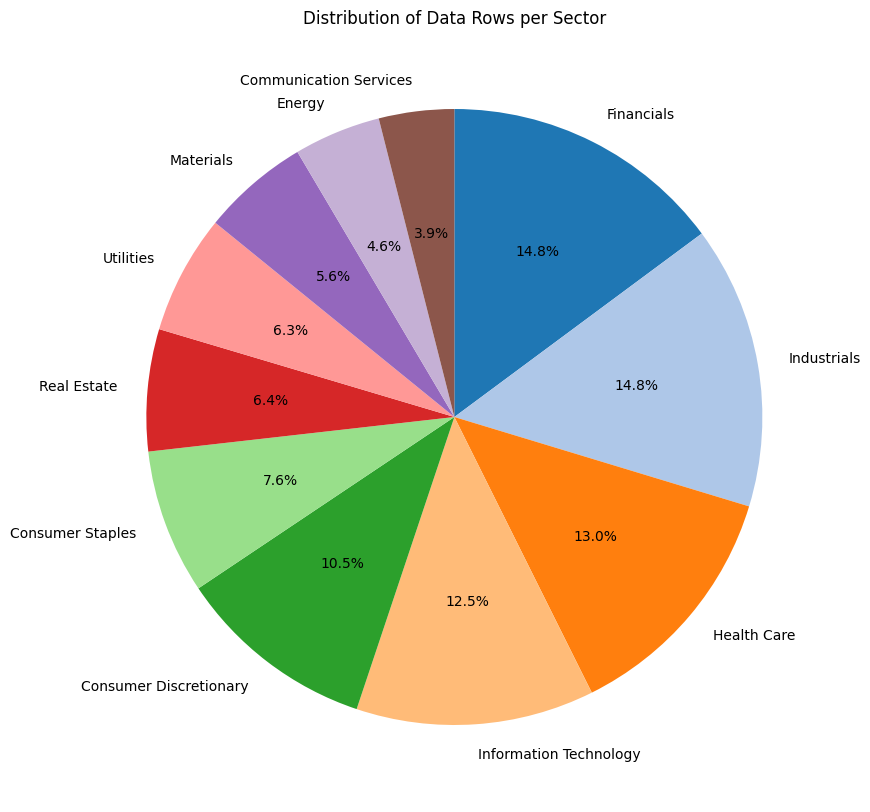

Sector
Financials                344512
Industrials               344424
Health Care               300541
Information Technology    290103
Consumer Discretionary    242996
Consumer Staples          176304
Real Estate               148466
Utilities                 145202
Materials                 130655
Energy                    105793
Communication Services     91654
dtype: int64


In [ ]:
sector_df = pd.Series(sp500_sectors).reset_index()
sector_df.columns = ['Ticker', 'Sector']


sector_df = pd.merge(all_stocks, sector_df, on='Ticker', how='left')
sector_row_counts = sector_df.groupby('Sector').size().sort_values(ascending=False)
colors = plt.cm.tab20(range(len(sector_row_counts)))

# Plot a pie chart of the row count distribution per sector
plt.figure(figsize=(10, 10))
sector_row_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, startangle=90, counterclock=False)
plt.title('Distribution of Data Rows per Sector')
plt.ylabel('')
plt.show()

# Output the row count distribution per sector
print(sector_row_counts)

## Correlation Metric Measurements

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


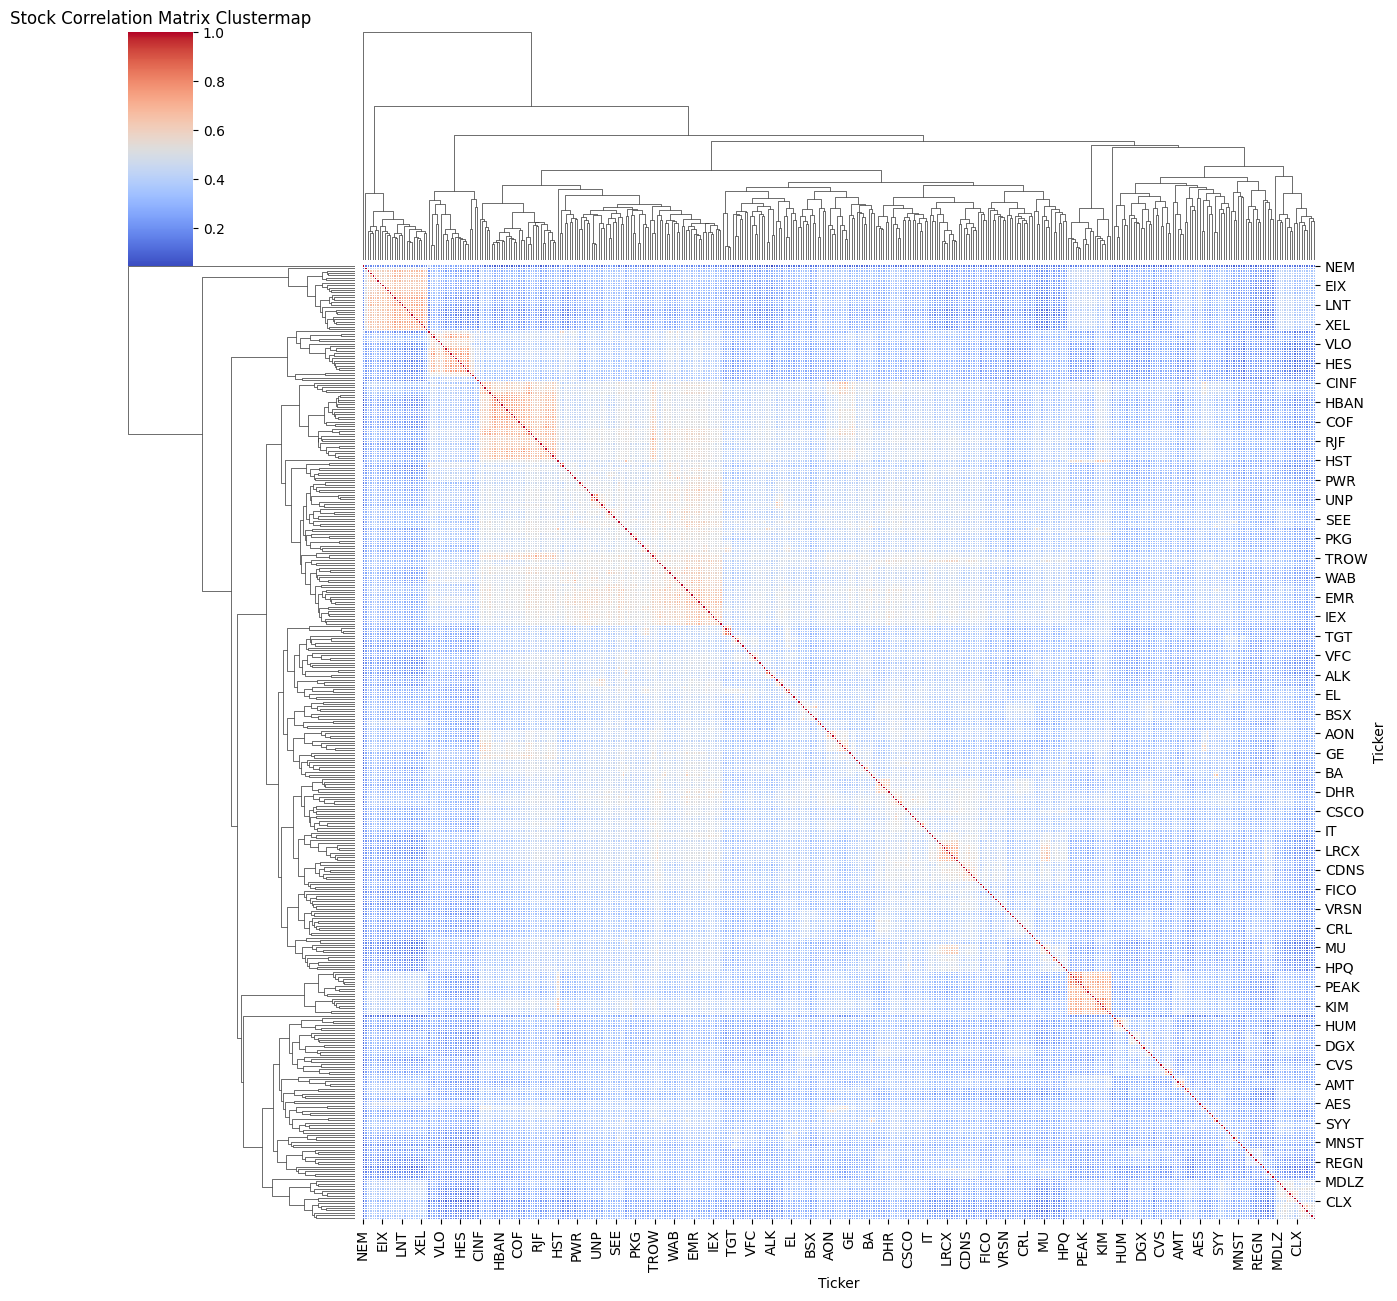

In [ ]:
metric = 'Log Return'
correlation_method = 'spearman' #spearman, pearson, kendall

correlation_matrix = all_stocks.pivot(index='Date', columns='Ticker', values= metric).dropna(axis=1).corr(method=correlation_method)

# Use Seaborn to create a heatmap
sns.clustermap(correlation_matrix, figsize=(13, 13), cmap='coolwarm', linewidths=.5)
plt.title('Stock Correlation Matrix Clustermap')
plt.show()

[0.45553625 0.14048198 0.09872002 0.04645058 0.03943819 0.02387348
 0.01637604 0.01133421 0.00916981 0.00689992]
[0.45553625 0.59601823 0.69473824 0.74118882 0.78062701 0.80450049
 0.82087653 0.83221075 0.84138056 0.84828048]


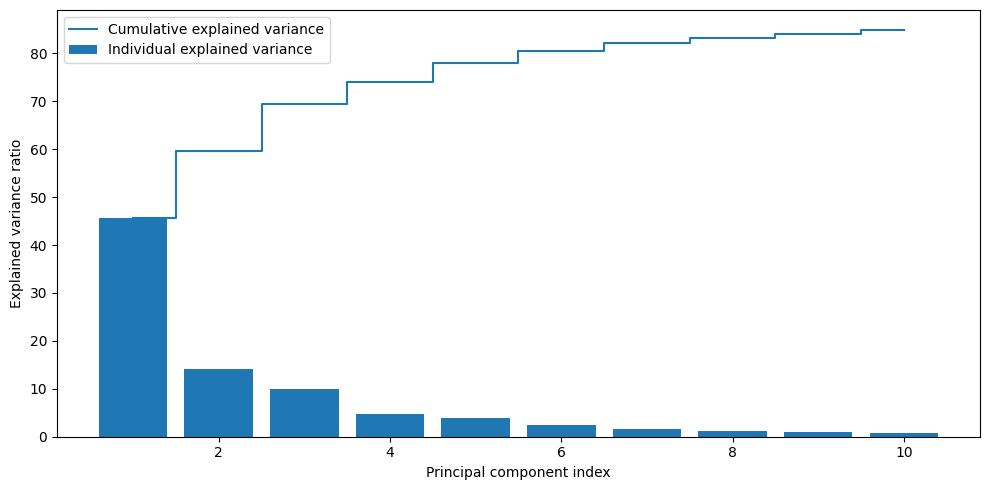

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(correlation_matrix)

n_components = 10
pca = PCA(n_components=n_components)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

explained_variance = pca.explained_variance_ratio_
print(explained_variance)

cumulative_variance = np.cumsum(explained_variance)
print(cumulative_variance)

plt.figure(figsize=(10, 5))
plt.bar(range(1, n_components+1), explained_variance * 100, label='Individual explained variance')
plt.step(range(1, n_components+1), cumulative_variance * 100, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Distribution Analysis

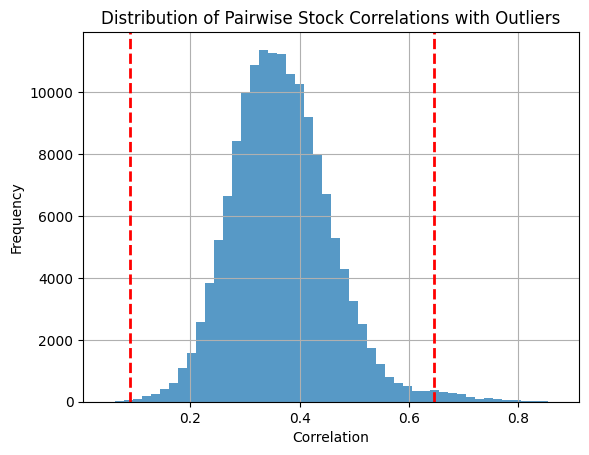

     Stock1 Stock2  Correlation   Z_score
0         A    MTD     0.648379  3.028404
1       ADI   AMAT     0.705883  3.649641
2       ADI   INTC     0.651616  3.063365
3       ADI   KLAC     0.712009  3.715829
4       ADI   LRCX     0.696110  3.544063
...     ...    ...          ...       ...
1725   ZION    PRU     0.677235  3.340139
1726   ZION     RF     0.772139  4.365431
1727   ZION    TFC     0.769737  4.339486
1728   ZION    USB     0.728964  3.898999
1729   ZION    WFC     0.706870  3.660302

[1730 rows x 4 columns]


In [ ]:
# Distribution of daily returns
flat_correlation_matrix = correlation_matrix.values.flatten()
mask_2d = np.ones_like(correlation_matrix, dtype=bool)
np.fill_diagonal(mask_2d, False)
correlations = flat_correlation_matrix[mask_2d.flatten()]
mean_corr = np.mean(correlations)
std_corr = np.std(correlations)
z_scores = (correlations - mean_corr) / std_corr


z_score_threshold = 3
outlier_mask = np.abs(z_scores) > z_score_threshold
outlier_correlations = correlations[outlier_mask]
outlier_z_scores = z_scores[outlier_mask]

# Extract the stock pairs for outliers from the flattened mask
stock_indices = np.where(mask_2d.flatten())[0][outlier_mask]
stock_pairs = [(correlation_matrix.index[i // correlation_matrix.shape[1]], correlation_matrix.columns[i % correlation_matrix.shape[1]])
               for i in stock_indices]

# Construct the DataFrame
outliers_df = pd.DataFrame({
    'Stock1': [i[0] for i in stock_pairs],
    'Stock2': [i[1] for i in stock_pairs],
    'Correlation': outlier_correlations,
    'Z_score': outlier_z_scores
})

# Plot the distribution of correlations including the outliers
plt.hist(correlations, bins=50, alpha=0.75)
plt.axvline(mean_corr + z_score_threshold * std_corr, color='r', linestyle='dashed', linewidth=2)
plt.axvline(mean_corr - z_score_threshold * std_corr, color='r', linestyle='dashed', linewidth=2)
plt.title('Distribution of Pairwise Stock Correlations with Outliers')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Show the DataFrame of outliers
print(outliers_df)

## Distribution of Actuals

(-0.05, 0.05)

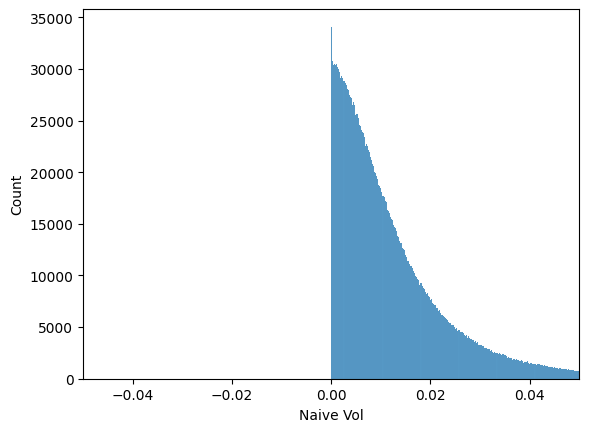

In [ ]:
sns.histplot(data=all_stocks, x="Naive Vol")
plt.xlim([-0.05, 0.05])

(-0.05, 0.05)

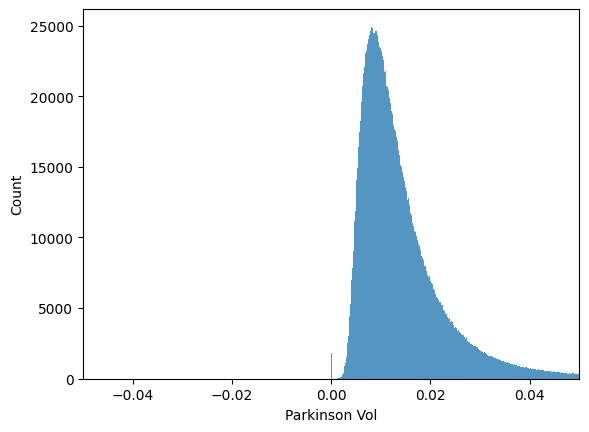

In [ ]:
sns.histplot(data=all_stocks, x="Parkinson Vol")
plt.xlim([-0.05, 0.05])

(-0.05, 0.05)

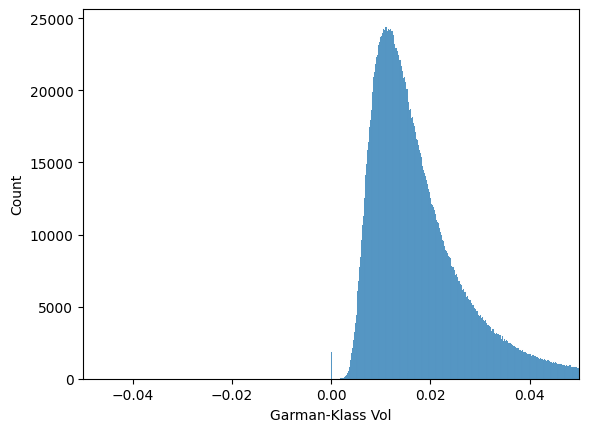

In [ ]:
sns.histplot(data=all_stocks, x="Garman-Klass Vol")
plt.xlim([-0.05, 0.05])

(-0.05, 0.05)

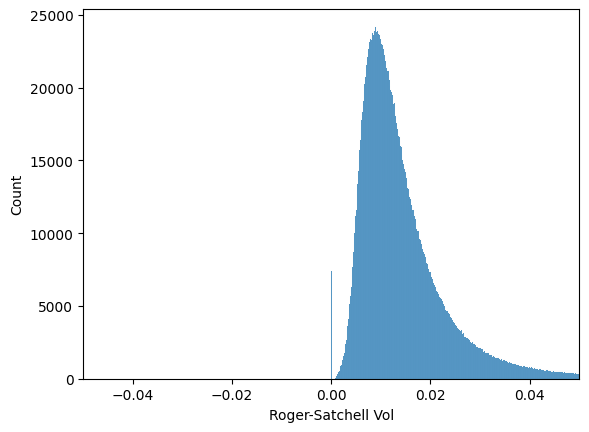

In [ ]:
sns.histplot(data=all_stocks, x='Roger-Satchell Vol')
plt.xlim([-0.05, 0.05])

(-0.05, 0.15)

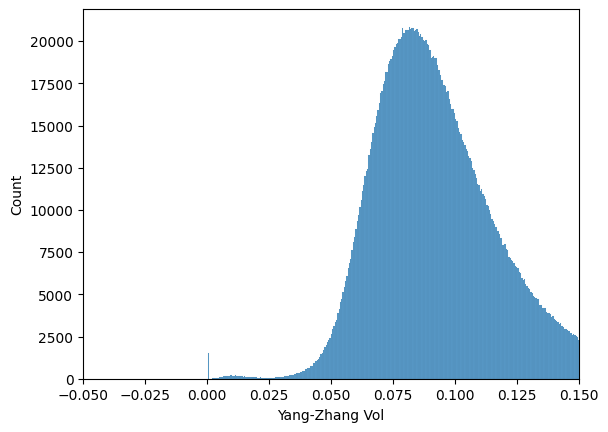

In [ ]:
sns.histplot(data=all_stocks, x='Yang-Zhang Vol')
plt.xlim([-0.05, 0.15])

# Modeling

## Splitting into Folds (Walk Forward Validation)

In [ ]:
# Split the data into walk-foward windows and seperate by ticker so it's easier to aggregate differences in results later
all_stocks.sort_values(by='Date', inplace=True)
train_length = 252
prediction_windows = [1, 5, 10, 20, 30]
buffer = 20

folds = defaultdict(lambda: defaultdict(list))
for ticker in tqdm(sp500_tickers, desc="Processing tickers"):
    ticker_data = all_stocks[all_stocks['Ticker'] == ticker]
    ticker_data = ticker_data.iloc[::-1].reset_index(drop=True)

    for prediction_window in prediction_windows:
        for end in range(len(ticker_data) - 1, -1, -1 * (train_length + prediction_window + buffer)):
            start = end - train_length - prediction_window
            if start >= 0:
                training_fold = ticker_data.iloc[start:start + train_length]
                testing_fold = ticker_data.iloc[start + train_length:end]
                folds[ticker][prediction_window].append((training_fold, testing_fold))
with open(f"{colab_path}/{stock_group}_{time_period}_folds.pkl", 'wb') as handle:
  pickle.dump(dict(folds), handle, protocol=pickle.HIGHEST_PROTOCOL)

Processing tickers: 100%|██████████| 503/503 [02:02<00:00,  4.12it/s]


In [ ]:
with open(f"{colab_path}/{stock_group}_{time_period}_folds.pkl", 'rb') as file:
    folds = pickle.load(file)

In [ ]:
def ctc_vol(datapoints):
    #print("CTC Vol")
    T = len(datapoints)
    mean = np.mean(datapoints['Close'])
    vol_sum = np.sum((datapoints['Close'] - mean) ** 2)
    return np.sqrt(vol_sum / max(T - 1, 1))

def parkinson_vol(datapoints, epsilon=1e-8):
    #print("Parkinson Vol")
    T = len(datapoints)
    coeff = 1 / (4 * T * np.log(2))
    vol_sum = np.sum(np.log((datapoints['High'] + epsilon)/(datapoints['Low'] + epsilon)) ** 2)
    return np.sqrt(coeff * vol_sum)

def garman_klass_vol(datapoints, epsilon=1e-8):
    #print("Garman Klass Vol")
    T = len(datapoints)
    first_term = (1 / (2 * T)) * np.sum(np.log((datapoints['High'] + epsilon) / (datapoints['Low'] + epsilon))**2)
    second_term = ((2 * np.log(2) - 1)/T) * np.sum(np.log((datapoints['Close'] + epsilon) / (datapoints['Open'] + epsilon))**2)
    return np.sqrt(max(0, first_term - second_term))

def rogers_satchell_vol(datapoints, epsilon = 1e-8):
    #print("Rogers Satchell Vol")
    T = len(datapoints)
    coeff = 1/T
    term_1 = np.log((datapoints['High'] + epsilon) / (datapoints['Close'] + epsilon)) * np.log((datapoints['High'] + epsilon) / (datapoints['Open'] + epsilon))
    term_2 = np.log((datapoints['Low'] + epsilon) / (datapoints['Close'] + epsilon)) * np.log((datapoints['Low'] + epsilon) / (datapoints['Open'] + epsilon))
    return np.sqrt(coeff * max(0, np.sum(term_1 + term_2)))

def yang_zhang_vol(datapoints, alpha = 1.34, epsilon = 1e-8):
    #print("Yang Zhang Vol")
    T = len(datapoints)
    k = (alpha - 1) / (alpha + (T + 1)/(max(1, T - 1)))
    coeff = 1/T
    overnight_vol = (1/max(1, T - 1)) * np.sum((np.log((datapoints['Open'] + epsilon) / (datapoints['Prev Close'] + epsilon)) - np.mean(np.log((datapoints['Open'] + epsilon) /(datapoints['Prev Close'] + epsilon))))**2)
    otc_vol = (1/max(1, T - 1)) * np.sum((np.log((datapoints['Close'] + epsilon) / (datapoints['Open'] + epsilon)) - np.mean(np.log((datapoints['Close'] + epsilon) /(datapoints['Open'] + epsilon))))**2)
    rs_vol = rogers_satchell_vol(datapoints)
    return np.sqrt(overnight_vol + k * otc_vol + (1 - k) * rs_vol ** 2)


In [ ]:
k = 5
train_length = 252
anomaly_std_threshold = 2.5
num_outlier_threshold = 0.03
prediction_windows = [1, 5, 10, 20, 30]
kf = KFold(n_splits=k, shuffle=True, random_state=42)
x_metric = "Daily Return"
y_metrics = [ctc_vol, parkinson_vol, garman_klass_vol, rogers_satchell_vol, yang_zhang_vol]

combined_folds = {pw: [{'train': {'Xs': [np.empty((0, train_length)) for _ in y_metrics], 'ys': [np.empty((0, 1)) for _ in y_metrics], 'tickers': []},
                        'test': {'Xs': [np.empty((0, train_length)) for _ in y_metrics], 'ys': [np.empty((0, 1)) for _ in y_metrics], 'tickers': []},
                        'anomalous': {'Xs': [np.empty((0, train_length)) for _ in y_metrics], 'ys': [np.empty((0, 1)) for _ in y_metrics], 'tickers': []}}
                       for _ in range(k)] for pw in prediction_windows}

# ON-OUTLIER Anonymous Folds
# def calculate_anomalous(y, mean, std, threshold):
#     return (np.abs(y - mean) > threshold * std).reshape(-1)

def calculate_anomalous(X, y, threshold, num_outlier_threshold, num_data = 252):
    means = np.mean(X, axis=1)
    stds = np.std(X, axis=1)
    outliers = np.abs(X - means[:, None]) > threshold * stds[:, None]
    num_outliers = np.sum(outliers, axis=1)
    anomalous = num_outliers > int(num_outlier_threshold * num_data)
    return anomalous

combined_folds['vol_types'] = ['CTC Vol', 'Parkinson Vol', 'Garman-Klass Vol', 'Roger-Satchell Vol', 'Yang-Zhang Vol']
for ticker in tqdm(folds,desc="Processing tickers"):
    for pw in folds[ticker]:
        fold_data = folds[ticker][pw]
        Xs = [np.array([fold[0][x_metric].to_list() for fold in fold_data]) for _ in y_metrics]
        ys = [np.array([y_metric(fold[1]) for fold in fold_data]).reshape(-1, 1) for y_metric in y_metrics]
        ticker_labels = [ticker] * len(Xs[0])

        if len(Xs[0]) < k:
            continue

        for fold_idx, (train_idx, test_idx) in enumerate(kf.split(Xs[0])):
            X_trains = [X[train_idx] for X in Xs]
            X_tests = [X[test_idx] for X in Xs]
            X_anoms = [None for _ in Xs]
            y_trains = [y[train_idx] for y in ys]
            y_tests = [y[test_idx] for y in ys]
            y_anoms = [None for _ in Xs]
            tickers_train = [ticker_labels[i] for i in train_idx]
            tickers_test = [ticker_labels[i] for i in test_idx]

            for i in range(len(X_tests)):
                X_test, y_test = X_tests[i], y_tests[i]
                anomalous_idx = calculate_anomalous(X_test, y_test, anomaly_std_threshold, num_outlier_threshold)

                X_anoms[i] = X_test[anomalous_idx, :]
                y_anoms[i] = y_test[anomalous_idx]
                X_tests[i] = X_test[~anomalous_idx, :]
                y_tests[i] = y_test[~anomalous_idx]

                tickers_anom = [ticker for ticker, is_anomalous in zip(tickers_test, anomalous_idx) if is_anomalous]
                tickers_test_new = [ticker for ticker, is_anomalous in zip(tickers_test, anomalous_idx) if not is_anomalous]

            # Combining data
            combined_folds[pw][fold_idx]['train']['Xs'] = [np.vstack([arr, X_train]) for arr, X_train in zip(combined_folds[pw][fold_idx]['train']['Xs'], X_trains)]
            combined_folds[pw][fold_idx]['train']['ys'] = [np.vstack([arr, y_train]) for arr, y_train in zip(combined_folds[pw][fold_idx]['train']['ys'], y_trains)]
            combined_folds[pw][fold_idx]['train']['tickers'].extend(tickers_train)

            combined_folds[pw][fold_idx]['test']['Xs'] =  [np.vstack([arr, X_test]) for arr, X_test in zip(combined_folds[pw][fold_idx]['test']['Xs'], X_tests)]
            combined_folds[pw][fold_idx]['test']['ys'] = [np.vstack([arr, y_test]) for arr, y_test in zip(combined_folds[pw][fold_idx]['test']['ys'], y_tests)]
            combined_folds[pw][fold_idx]['test']['tickers'].extend(tickers_test_new)

            combined_folds[pw][fold_idx]['anomalous']['Xs'] =  [np.vstack([arr, X_anom]) for arr, X_anom in zip(combined_folds[pw][fold_idx]['anomalous']['Xs'], X_anoms)]
            combined_folds[pw][fold_idx]['anomalous']['ys'] = [np.vstack([arr, y_anom]) for arr, y_anom in zip(combined_folds[pw][fold_idx]['anomalous']['ys'], y_anoms)]
            combined_folds[pw][fold_idx]['anomalous']['tickers'].extend(tickers_anom)
with open(f"{colab_path}/{stock_group}_{time_period}_combined_anomalous_folds.pkl", 'wb') as handle:
    pickle.dump(combined_folds, handle, protocol=pickle.HIGHEST_PROTOCOL)


Processing tickers: 100%|██████████| 500/500 [09:11<00:00,  1.10s/it]


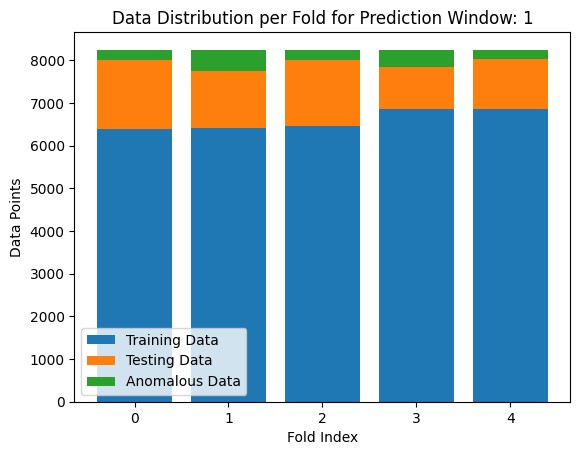

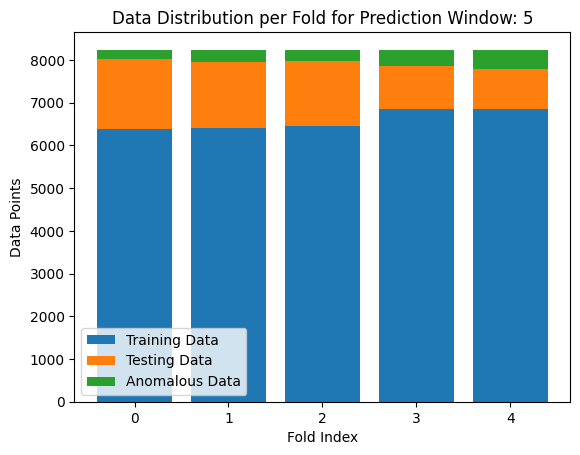

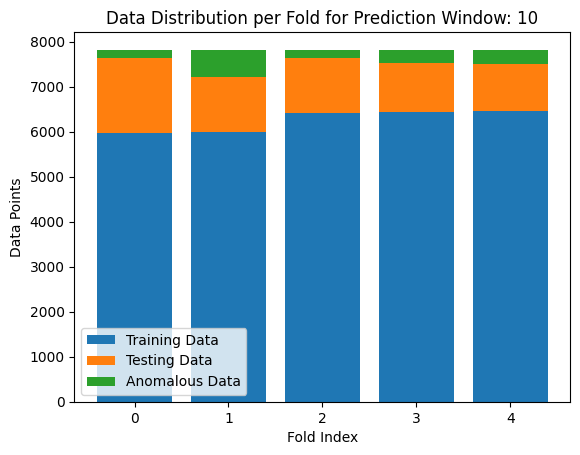

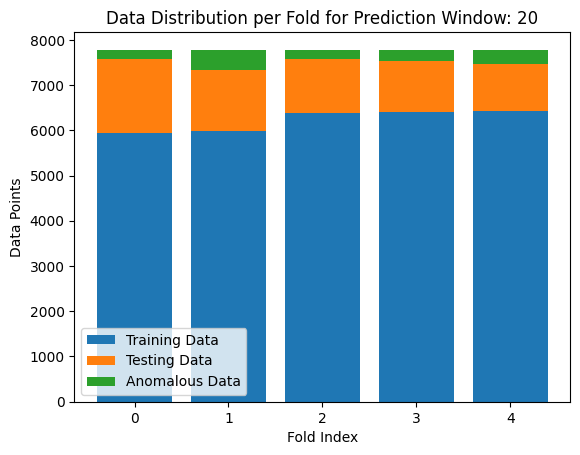

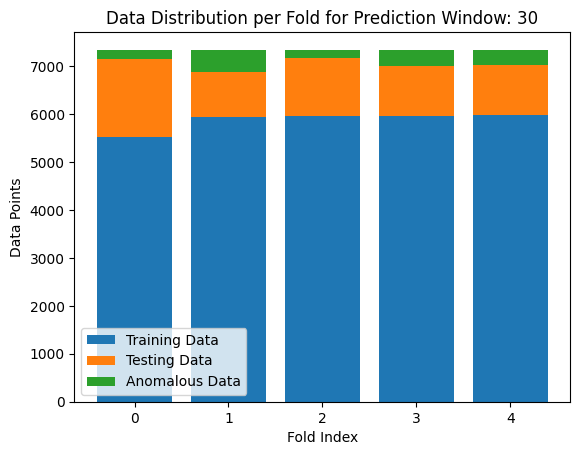

In [ ]:
with open(f"{colab_path}/{stock_group}_{time_period}_combined_anomalous_folds.pkl", 'rb') as file:
    combined_folds = pickle.load(file)

for pw in combined_folds:
    if pw != 'vol_types':
      train_sizes = []
      test_sizes = []
      anomalous_sizes = []
      for fold in combined_folds[pw]:
          train_sizes.append(len(fold['train']['tickers']))
          test_sizes.append(len(fold['test']['tickers']))
          anomalous_sizes.append(len(fold['anomalous']['tickers']))
      fig, ax = plt.subplots()
      ax.bar(range(len(train_sizes)), train_sizes, label='Training Data')
      ax.bar(range(len(test_sizes)), test_sizes, label='Testing Data', bottom=train_sizes)
      ax.bar(range(len(anomalous_sizes)), anomalous_sizes, label='Anomalous Data', bottom=[train_sizes[i] + test_sizes[i] for i in range(len(train_sizes))])
      ax.set_xlabel('Fold Index')
      ax.set_ylabel('Data Points')
      ax.set_title(f'Data Distribution per Fold for Prediction Window: {pw}')
      ax.legend()

      plt.xticks(range(len(train_sizes)))
      plt.show()


In [ ]:
class TickerDataset(Dataset):
    def __init__(self, Xs, ys, tickers):
        self.Xs = Xs
        self.ys = ys
        self.tickers = tickers

    def __len__(self):
        return len(self.Xs[0])

    def __getitem__(self, idx):
        return {
            'Xs': [torch.tensor(X[idx], dtype=torch.float) for X in self.Xs],
            'ys': [torch.tensor(y[idx], dtype=torch.float) for y in self.ys],
            'ticker': self.tickers[idx]
        }

In [ ]:
batch_size = 32
data_loaders = {pw: {'train': [], 'test': [], 'anomalous': []} for pw in combined_folds}
for pw in combined_folds:
    if pw != 'vol_types':
        for fold in combined_folds[pw]:
            train_dataset = TickerDataset(fold['train']['Xs'], fold['train']['ys'], fold['train']['tickers'])
            test_dataset = TickerDataset(fold['test']['Xs'], fold['test']['ys'], fold['test']['tickers'])
            anom_dataset = TickerDataset(fold['anomalous']['Xs'], fold['anomalous']['ys'], fold['anomalous']['tickers'])

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            anom_loader = DataLoader(anom_dataset, batch_size=batch_size, shuffle=False)

            data_loaders[pw]['train'].append(train_loader)
            data_loaders[pw]['test'].append(test_loader)
            data_loaders[pw]['anomalous'].append(anom_loader)

______

## Naive Models

### Hist Model

In [ ]:
def hist_model(data_loaders, static = True, data_names = ['train', 'test', 'anomalous']):
    results = {}
    prediction_windows = [1, 5, 10, 20, 30]

    for pw in tqdm(prediction_windows, desc='HIST Model'):
        results[pw] = {}
        loader_sets = [data_loaders[pw][name] for name in data_names]
        for fold_idx, loaders in enumerate(zip(*loader_sets)):

          results[pw][fold_idx] = {f"{name}-tickers": [] for name in data_names}

          for loader, name in zip(loaders, data_names):
              for batch in loader:
                  if f"{name}-prediction" not in results[pw][fold_idx]:
                      results[pw][fold_idx][f"{name}-prediction"] = [torch.empty((0, 1)) for _ in batch['Xs']]
                  if f"{name}-actual" not in results[pw][fold_idx]:
                      results[pw][fold_idx][f"{name}-actual"] = [torch.empty((0, 1)) for _ in batch['ys']]

                  for n in range(len(batch['Xs'])):
                      batch_X = batch['Xs'][n]
                      if static:
                          prediction = torch.std(batch_X, axis = 1).reshape((-1, 1))
                      else:
                          predictions = []
                          for i in range(pw):
                              prediction = torch.std(batch_X[:, i:], axis = 1).reshape((-1, 1))
                              batch_X = torch.cat((batch_X, prediction), dim=1)
                              predictions.append(prediction)
                          prediction = torch.mean(torch.stack(predictions), axis=0).reshape((-1, 1))
                      results[pw][fold_idx][f"{name}-prediction"][n] = torch.cat((results[pw][fold_idx][f"{name}-prediction"][n], prediction))

                  results[pw][fold_idx][f"{name}-actual"] = [torch.cat((actual, y)) for actual, y in zip(results[pw][fold_idx][f"{name}-actual"], batch['ys'])]
                  results[pw][fold_idx][f"{name}-tickers"] += batch['ticker']

    return results

### EWMA Model
EWMA is an extension of HIST where you weigh the more recent variances more strongly by decaying older posts.


In [ ]:
def ewma_model(data_loaders, lambda_decay = 0.94, static = True,  data_names = ['train', 'test', 'anomalous']):
    results = {}
    prediction_windows = [1, 5, 10, 20, 30]

    for pw in tqdm(prediction_windows, desc='EWMA Model'):
        results[pw] = {}
        loader_sets = [data_loaders[pw][name] for name in data_names]

        for fold_idx, loaders in enumerate(zip(*loader_sets)):
            results[pw][fold_idx] = {f"{name}-tickers": [] for name in data_names}

            for loader, name in zip(loaders, data_names):
                for batch in loader:
                  if f"{name}-prediction" not in results[pw][fold_idx]:
                      results[pw][fold_idx][f"{name}-prediction"] = [torch.empty((0, 1)) for _ in batch['Xs']]
                  if f"{name}-actual" not in results[pw][fold_idx]:
                      results[pw][fold_idx][f"{name}-actual"] = [torch.empty((0, 1)) for _ in batch['ys']]

                  for n in range(len(batch['Xs'])):
                      batch_X = batch['Xs'][n]

                      weights = [(1 - lambda_decay) * (lambda_decay ** n) for n in range(batch_X.shape[0])]
                      weights = torch.FloatTensor(weights).unsqueeze(1)
                      if static:
                          average = (torch.sum(batch_X * weights, axis = 1) / torch.sum(weights)).unsqueeze(1)
                          variance = torch.sum(torch.square(batch_X - average) * weights, axis = 1) / torch.sum(weights)
                          prediction = torch.sqrt(variance).unsqueeze(1)
                      else:
                        predictions = []
                        for i in range(pw):
                            average = (torch.sum(batch_X[:, i:] * weights, axis = 1) / torch.sum(weights)).unsqueeze(1)
                            variance = torch.sum(torch.square(batch_X[:, i:] - average) * weights, axis = 1) / torch.sum(weights)
                            prediction = torch.sqrt(variance).unsqueeze(1)
                            batch_X = torch.cat((batch_X, prediction), dim=1)
                            predictions.append(prediction)
                        prediction = torch.mean(torch.stack(predictions), axis=0).reshape((-1, 1))
                      results[pw][fold_idx][f"{name}-prediction"][n] = torch.cat((results[pw][fold_idx][f"{name}-prediction"][n], prediction))

                  results[pw][fold_idx][f"{name}-actual"] = [torch.cat((actual, y)) for actual, y in zip(results[pw][fold_idx][f"{name}-actual"], batch['ys'])]
                  results[pw][fold_idx][f"{name}-tickers"] += batch['ticker']

    return results

## Garch Model

Hansen and Lund (2004) provided compelling evidence that is difficult to find a volatility model that outperforms the simple GARCH(1,1). Hence, for many purposes the GARCH(1,1) model is the de facto volatility model of choice for daily returns

In [ ]:
def garch_model(data_loaders, scale = 100, data_names = ['train', 'test', 'anomalous']):
    results = {}
    prediction_windows = [1, 5, 10, 20, 30]

    for pw in tqdm(prediction_windows, desc='Garch Model'):
        results[pw] = {}
        loader_sets = [data_loaders[pw][name] for name in data_names]

        for fold_idx, loaders in enumerate(tqdm(zip(*loader_sets), desc=f'Fold (PW={pw})', position=1)):
            results[pw][fold_idx] = {f"{name}-tickers": [] for name in data_names}

            for loader, name in tqdm(zip(loaders, data_names), desc='Data Name', position=2):
                for batch in tqdm(loader, desc='Batch', position=3):
                    if f"{name}-prediction" not in results[pw][fold_idx]:
                      results[pw][fold_idx][f"{name}-prediction"] = [torch.empty((0, 1)) for _ in batch['Xs']]
                    if f"{name}-actual" not in results[pw][fold_idx]:
                      results[pw][fold_idx][f"{name}-actual"] = [torch.empty((0, 1)) for _ in batch['ys']]

                    for n in range(len(batch['Xs'])):
                        batch_X = batch['Xs'][n]
                        predictions = []

                        for i in range(batch_X.shape[0]):
                            model = arch_model(scale * batch_X[i].numpy(), vol='Garch', p=1, q=1)
                            model_fit = model.fit(disp='off')
                            forecast = model_fit.forecast(horizon=pw)
                            prediction = forecast.variance.iloc[-1, :]
                            predictions.append(prediction.values[0])

                        prediction = (torch.tensor(predictions) / scale).reshape(-1, 1)

                        results[pw][fold_idx][f"{name}-prediction"][n] = torch.cat((results[pw][fold_idx][f"{name}-prediction"][n], prediction))

                    results[pw][fold_idx][f"{name}-actual"] = [torch.cat((actual, y)) for actual, y in zip(results[pw][fold_idx][f"{name}-actual"], batch['ys'])]
                    results[pw][fold_idx][f"{name}-tickers"] += batch['ticker']
    return results

______

# Analyzing Results

In [ ]:
# Collect all results
global_results = {}
global_results["HIST-static"] = hist_model(data_loaders)
global_results["HIST-dynamic"] = hist_model(data_loaders, static = False)
global_results["EWMA-static"] = ewma_model(data_loaders)
global_results["EWMA-dynamic"] = ewma_model(data_loaders, static = False)

with open(f"{colab_path}/global_results.pkl", 'wb') as file:
    pickle.dump(global_results, file)

EWMA Model: 100%|██████████| 5/5 [01:28<00:00, 17.74s/it]


In [ ]:
with open(f"{colab_path}/global_results.pkl", 'rb') as file:
    global_results = pickle.load(file)

global_results["GARCH"] = garch_model(data_loaders)

with open(f"{colab_path}/global_results.pkl", 'wb') as file:
    pickle.dump(global_results, file)

Garch Model:   0%|          | 0/5 [00:00<?, ?it/s]
Fold (PW=1): 0it [00:00, ?it/s]

Data Name: 0it [00:00, ?it/s]


Batch:   0%|          | 0/201 [00:00<?, ?it/s]



Xs:   0%|          | 0/5 [00:00<?, ?it/s]



Xs:  20%|██        | 1/5 [00:02<00:08,  2.02s/it]



Xs:  40%|████      | 2/5 [00:03<00:04,  1.46s/it]



Xs:  60%|██████    | 3/5 [00:04<00:02,  1.34s/it]



Xs:  80%|████████  | 4/5 [00:05<00:01,  1.31s/it]



Xs: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]



Batch:   0%|          | 1/201 [00:06<22:50,  6.85s/it]



Xs:   0%|          | 0/5 [00:00<?, ?it/s]



Xs:  20%|██        | 1/5 [00:01<00:04,  1.23s/it]



Xs:  40%|████      | 2/5 [00:02<00:03,  1.09s/it]



Xs:  60%|██████    | 3/5 [00:03<00:01,  1.04it/s]



Xs:  80%|████████  | 4/5 [00:03<00:00,  1.09it/s]



Xs: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]



Batch:   1%|          | 2/201 [00:11<18:35,  5.61s/it]



Xs:   0%|          | 0/5 [00:00<?, ?it/s]



Xs:  20%|██        | 1/5 [00:00<00:03,  1.17it/s]





KeyboardInterrupt: ignored

## Accuracies across metrics

In [ ]:
with open(f"{colab_path}/global_results.pkl", 'rb') as file:
    global_results = pickle.load(file)


# def calculate_mse(predictions, actuals):
#     """Calculate Mean Squared Error using PyTorch."""
#     return torch.mean((predictions - actuals) ** 2)

def calculate_rmse(actuals, predictions):
    """Calculate Root Mean Squared Error using PyTorch."""
    return np.sqrt(mean_squared_error(actuals, predictions))

# def calculate_r_squared(predictions, actuals):
#     """Calculate R-squared using PyTorch."""
#     ss_res = torch.sum((actuals - predictions) ** 2)
#     ss_tot = torch.sum((actuals - torch.mean(actuals)) ** 2)
#     return 1 - (ss_res / ss_tot)

# def calculate_explained_variance(predictions, actuals):
#     """Calculate Explained Variance Score using PyTorch."""
#     variance_res = torch.var(actuals - predictions)
#     variance_tot = torch.var(actuals)
#     return 1 - (variance_res / variance_tot)

def calculate_mape(actuals, predictions):
    """Calculate Absolute Percent Error."""
    predictions = predictions[actuals != 0]
    actuals = actuals[actuals != 0]
    mape = torch.mean(torch.abs((actuals - predictions) / actuals))

    if torch.isnan(mape):
        print("Predictions:", predictions)
        print("Actuals:", actuals)

    return mape


with open(f"{colab_path}/summ_accuracy_results.pkl", 'rb') as file:
    acc_results = pickle.load(file)

def summarize_accuracy(global_results,
                       metric_functions = [
                            ("mse", mean_squared_error),
                            ("rmse", calculate_rmse),
                            ("r_squared", r2_score),
                            ("explained_variance", explained_variance_score),
                            ("mape", calculate_mape)
                        ],
                       data_types = ['train', 'test', 'anomalous'],
                       num_y_metrics = 5):
    acc_results = {}

    for name, function in metric_functions:
        acc_results[name] = {}
        for model_name in tqdm(global_results, desc = f"Calculating {name} accuracy"):
            acc_results[name][model_name] = {}
            model = global_results[model_name]
            for pw in model:
                acc_results[name][model_name][pw] = {}
                for data_type in data_types:
                    acc_results[name][model_name][pw][data_type] = {}
                    ticker_results = {"all": [torch.zeros(1) for _ in range(num_y_metrics)]}
                    for fold_idx, fold_data in model[pw].items():
                          predictions = fold_data[f"{data_type}-prediction"]
                          actuals = fold_data[f"{data_type}-actual"]
                          tickers = fold_data[f"{data_type}-tickers"]
                          accs = [function(ta[~torch.isnan(tp) & ~torch.isnan(ta)], tp[~torch.isnan(tp) & ~torch.isnan(ta)]) for tp, ta in zip(predictions, actuals)]
                          ticker_results['all'] = [acc + tr for acc, tr in zip(accs, ticker_results['all'])]
                          if name == "mape":
                              ta = predictions[0]
                              tp = actuals[0]
                              print(ta)
                              print(tp)
                              print(ta[~torch.isnan(tp) & ~torch.isnan(ta)])
                              print(tp[~torch.isnan(tp) & ~torch.isnan(ta)])

                              print(ticker_results['all'])

                          # # Calculate ACC for each ticker
                          # for ticker in set(tickers):
                          #     if ticker not in ticker_results:
                          #         ticker_results[ticker] = [torch.zeros(1) for _ in range(num_y_metrics)]

                          #     ticker_indices = torch.IntTensor([i for i, t in enumerate(tickers) if t == ticker])
                          #     ticker_predictions = [prediction[ticker_indices] for prediction in predictions]
                          #     ticker_actuals = [actual[ticker_indices] for actual in actuals]

                          #     accs = [function(tp, ta) for tp, ta in zip(ticker_predictions, ticker_actuals)]
                          #     ticker_results[ticker] = [acc + tr for acc, tr in zip(accs, ticker_results[ticker])]

                    for ticker in ticker_results:
                        ticker_results[ticker] = [tr / len(model[pw]) for tr in ticker_results[ticker]]
                    acc_results[name][model_name][pw][data_type] = ticker_results
    return acc_results

acc_results = summarize_accuracy(global_results)
# mape_results = summarize_accuracy(global_results, metric_functions = [("mape", calculate_mape)])
with open(f"{colab_path}/summ_accuracy_results.pkl", 'wb') as file:
    pickle.dump(acc_results, file)

Calculating mape accuracy:   0%|          | 0/4 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
        0.0127, 0.0237, 0.0215, 0.0261, 0.0194, 0.0174, 0.0251, 0.0150, 0.0138,
        0.0240, 0.0243, 0.0237, 0.0153, 0.0216, 0.0168, 0.0261, 0.0135, 0.0175,
        0.0356, 0.0192, 0.0167, 0.0227, 0.0130, 0.0133, 0.0112, 0.0204, 0.0289,
        0.0147, 0.0438, 0.0388, 0.0191, 0.0134, 0.0142, 0.0318, 0.0310, 0.0216,
        0.0156, 0.0162, 0.0186, 0.0306, 0.0165, 0.0169, 0.0302, 0.0149, 0.0168,
        0.0283, 0.0262, 0.0142, 0.0193, 0.0175, 0.0276, 0.0248])
tensor([1.4946e+00, 6.9362e+00, 2.3895e-01, 2.3471e+00, 5.7541e-01, 1.1458e+01,
        2.5698e-01, 9.7199e-01, 1.3311e+00, 4.4414e-01, 6.6081e-01, 2.6225e+00,
        7.6385e-01, 7.6316e-01, 3.2123e+00, 1.8066e+00, 1.1938e+00, 6.7983e-01,
        4.5362e+00, 8.8010e+00, 5.0634e-01, 2.6429e+00, 3.1667e-01, 3.0845e-01,
        1.6085e+00, 6.2153e-01, 1.8001e+00, 1.3924e+00, 3.1586e-01, 3.2104e+00,
        3.9283e-01, 6.3708e-01, 4.2532e-01, 1.9032e+00, 1.7533e+00, 4.4669e-01,
    

Calculating mape accuracy:  25%|██▌       | 1/4 [00:01<00:05,  1.93s/it]

Streaming output truncated to the last 5000 lines.
        [7.4804e-01],
        [1.2667e+00],
        [2.7237e-01],
        [7.3525e-01],
        [3.4767e-01],
        [9.1369e-01],
        [1.7339e+00],
        [3.1955e-01],
        [1.4140e+00],
        [3.6545e-01],
        [3.3784e+00],
        [1.7606e+00],
        [1.1288e+00],
        [1.1186e+00],
        [1.4231e+00],
        [1.6475e+00],
        [2.7513e+00],
        [8.5461e-01],
        [1.1329e+02],
        [7.9285e-01],
        [9.0204e-01],
        [9.4922e-01],
        [1.1235e+00],
        [1.0519e+00],
        [5.3147e-01],
        [6.6284e-01],
        [1.0901e+00],
        [2.7534e+00],
        [3.4728e-01],
        [5.5000e-01],
        [6.7556e-01],
        [6.5143e+00],
        [4.1880e+00],
        [6.4863e-01],
        [1.7113e+00],
        [4.8626e-01],
        [7.3236e-01],
        [5.8255e-01],
        [5.6577e-01],
        [8.4695e-01],
        [4.3705e-01],
        [6.0189e-01],
        [5.1020e-01],
   

Calculating mape accuracy:  50%|█████     | 2/4 [00:03<00:03,  1.92s/it]

Streaming output truncated to the last 5000 lines.
        [3.7556e+00],
        [6.2580e-02],
        [5.4597e-01],
        [6.5737e-01],
        [8.5810e-01],
        [2.8278e-01],
        [1.3170e+00],
        [1.3436e+00],
        [4.1179e-01],
        [2.3143e-01],
        [7.6824e-01],
        [2.3187e+00],
        [1.8836e+00],
        [3.0753e+00],
        [1.1638e+00],
        [2.6783e+00],
        [4.1711e-01],
        [4.1029e-01],
        [1.1667e+00],
        [2.0593e+00],
        [8.5501e-01],
        [4.0573e-01],
        [7.5590e-01],
        [4.4719e+00],
        [4.8326e-01],
        [2.0462e-01],
        [2.2575e+00],
        [3.0951e+00],
        [8.8278e-01],
        [6.5571e-01],
        [1.9792e+00],
        [1.0710e+00],
        [2.0279e+00],
        [9.1946e-01],
        [1.4951e+00],
        [1.5259e+00],
        [1.6109e-01],
        [7.2885e+00],
        [3.2503e-01],
        [1.1422e+00],
        [4.1395e-01],
        [3.7116e-01],
        [7.1231e-01],
   

Calculating mape accuracy:  75%|███████▌  | 3/4 [00:05<00:01,  1.88s/it]

Streaming output truncated to the last 5000 lines.
        [6.8655e-02],
        [7.3974e-02],
        [1.0326e-01],
        [5.5420e-02],
        [5.4003e-02],
        [6.6362e-02],
        [3.2257e-02],
        [4.5062e-02],
        [2.6226e-02],
        [1.8434e-02],
        [3.2577e-02],
        [3.9304e-02],
        [3.4744e-02],
        [2.2376e-02],
        [2.2854e-02],
        [5.2539e-02],
        [1.5189e-02],
        [6.1796e+00],
        [4.4646e+00],
        [1.0137e+01],
        [2.2116e+00],
        [2.4945e+00],
        [1.1357e+00],
        [7.2451e-01],
        [3.9077e-01],
        [5.6020e-01],
        [2.7387e-01],
        [1.1795e-01],
        [1.4785e-01],
        [8.2955e-02],
        [1.7957e-01],
        [1.6607e-01],
        [1.6079e-01],
        [1.0614e-01],
        [1.1437e-01],
        [6.0557e-02],
        [3.4829e-02],
        [3.1763e-02],
        [1.7178e-01],
        [1.4372e-01],
        [2.7949e-02],
        [2.1727e-02],
        [3.6410e-02],
   

Calculating mape accuracy: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]

tensor([[ 1.7714],
        [ 0.2968],
        [ 2.4045],
        [ 0.7088],
        [ 7.3169],
        [ 1.0005],
        [ 2.1666],
        [ 0.8607],
        [ 3.1325],
        [ 0.4329],
        [ 1.3013],
        [ 3.4435],
        [ 3.4529],
        [ 1.1871],
        [ 1.5626],
        [ 1.8979],
        [29.5257],
        [ 0.7686],
        [ 2.1476],
        [ 2.8236],
        [ 0.2599],
        [ 0.7761],
        [ 2.6269],
        [ 1.0676],
        [ 4.6944],
        [ 2.7246],
        [ 2.2878],
        [ 1.4876],
        [ 1.1102],
        [ 2.0864],
        [ 0.5456],
        [ 4.9142],
        [ 0.3074],
        [ 0.4096],
        [ 0.5422],
        [ 0.7088],
        [ 2.2294],
        [ 2.6480],
        [ 1.3075],
        [ 6.6074],
        [14.0313],
        [ 0.7307],
        [ 2.1434],
        [ 1.3353],
        [ 2.1613],
        [ 0.2216],
        [ 0.7959],
        [ 0.5150],
        [ 0.1830],
        [ 1.8901],
        [ 0.5873],
        [ 1.1633],
        [ 1.

In [ ]:
with open(f"{colab_path}/summ_accuracy_results.pkl", 'rb') as file:
    acc_results = pickle.load(file)
acc_results

{'mse': {'HIST-static': {1: {'train': {'all': [tensor([0.0005])]},
    'test': {'all': [tensor([0.0004])]},
    'anomalous': {'all': [tensor([0.0006])]}},
   5: {'train': {'all': [tensor([0.0005])]},
    'test': {'all': [tensor([0.0005])]},
    'anomalous': {'all': [tensor([0.0006])]}},
   10: {'train': {'all': [tensor([0.0005])]},
    'test': {'all': [tensor([0.0005])]},
    'anomalous': {'all': [tensor([0.0006])]}},
   20: {'train': {'all': [tensor([0.0005])]},
    'test': {'all': [tensor([0.0005])]},
    'anomalous': {'all': [tensor([0.0007])]}},
   30: {'train': {'all': [tensor([0.0005])]},
    'test': {'all': [tensor([0.0005])]},
    'anomalous': {'all': [tensor([0.0006])]}}},
  'HIST-dynamic': {1: {'train': {'all': [tensor([0.0005])]},
    'test': {'all': [tensor([0.0004])]},
    'anomalous': {'all': [tensor([0.0006])]}},
   5: {'train': {'all': [tensor([0.0005])]},
    'test': {'all': [tensor([0.0005])]},
    'anomalous': {'all': [tensor([0.0006])]}},
   10: {'train': {'all': [t

In [ ]:
def acc_to_df(acc_results, vol_names = ['CTC Vol', 'Parkinson Vol', 'Garman-Klass Vol', 'Roger-Satchell Vol', 'Yang-Zhang Vol']):
    data = []
    for loss_metric, models in acc_results.items():
        for model_name, prediction_windows in models.items():
            for pw, type_data in prediction_windows.items():
                typ_dicts = []
                for i, (typ, ticker_data) in enumerate(type_data.items()):
                    for j, (ticker, accuracy_list) in enumerate(ticker_data.items()):
                        for k, (accuracy, vol_name) in enumerate(zip(accuracy_list, vol_names)):
                            dict_index = j * len(vol_names) + k
                            if isinstance(accuracy, torch.Tensor):
                                accuracy = accuracy.item()
                            if i == 0:
                                typ_dicts.append({
                                    "Volatility Type": vol_name,
                                    "Loss Metric": loss_metric,
                                    "Model Name": model_name,
                                    "Prediction Window": pw,
                                    "Ticker": ticker,
                                    f"{typ}-error": accuracy
                                })
                            else:
                                typ_dicts[dict_index][f"{typ}-error"] = accuracy
                data += typ_dicts

    return pd.DataFrame(data)

# print(acc_results.keys())
acc_df = acc_to_df(acc_results)
# print(acc_df.shape)
# print(acc_df.head())

# mape_df = acc_to_df(mape_results)

In [ ]:
acc_df[(acc_df['Ticker'] == 'all') & (acc_df['Loss Metric'] == 'rmse')]
# pd.options.display.float_format = '{:.3f}'.format
# mape_df[mape_df['Ticker'] == 'all']

,Volatility Type,Loss Metric,Model Name,Prediction Window,Ticker,train-error,test-error,anomalous-error
25,CTC Vol,rmse,HIST-static,1,all,2.206067e-02,2.093927e-02,2.503061e-02
26,CTC Vol,rmse,HIST-static,5,all,2.201777e-02,2.101522e-02,2.480784e-02
27,CTC Vol,rmse,HIST-static,10,all,2.235627e-02,2.151091e-02,2.460300e-02
28,CTC Vol,rmse,HIST-static,20,all,2.231829e-02,2.143522e-02,2.534223e-02
29,CTC Vol,rmse,HIST-static,30,all,2.238717e-02,2.150567e-02,2.478984e-02
30,CTC Vol,rmse,HIST-dynamic,1,all,2.206067e-02,2.093927e-02,2.503061e-02
31,CTC Vol,rmse,HIST-dynamic,5,all,2.200851e-02,2.101281e-02,2.478306e-02
32,CTC Vol,rmse,HIST-dynamic,10,all,2.233150e-02,2.146404e-02,2.457312e-02
33,CTC Vol,rmse,HIST-dynamic,20,all,2.239703e-02,2.149910e-02,2.542047e-02
34,CTC Vol,rmse,HIST-dynamic,30,all,2.247424e-02,2.154512e-02,2.492771e-02


In [ ]:
def junk_visualize_accuracy(df):
    grouped = df.groupby(['Loss Metric', 'Model Name', 'Prediction Window'])
    for (loss_metric, model_name, pw), group in grouped:
        plt.figure(figsize=(10, 6))
        plt.bar(group['Ticker'], group['Accuracy'], color='skyblue')
        plt.xlabel('Ticker')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy for {loss_metric} - {model_name} - PW: {pw}')
        plt.xticks(rotation=45)

        plt.savefig(f"{colab_path}/images/{loss_metric}_{model_name}_PW{pw}.png")
        plt.close()

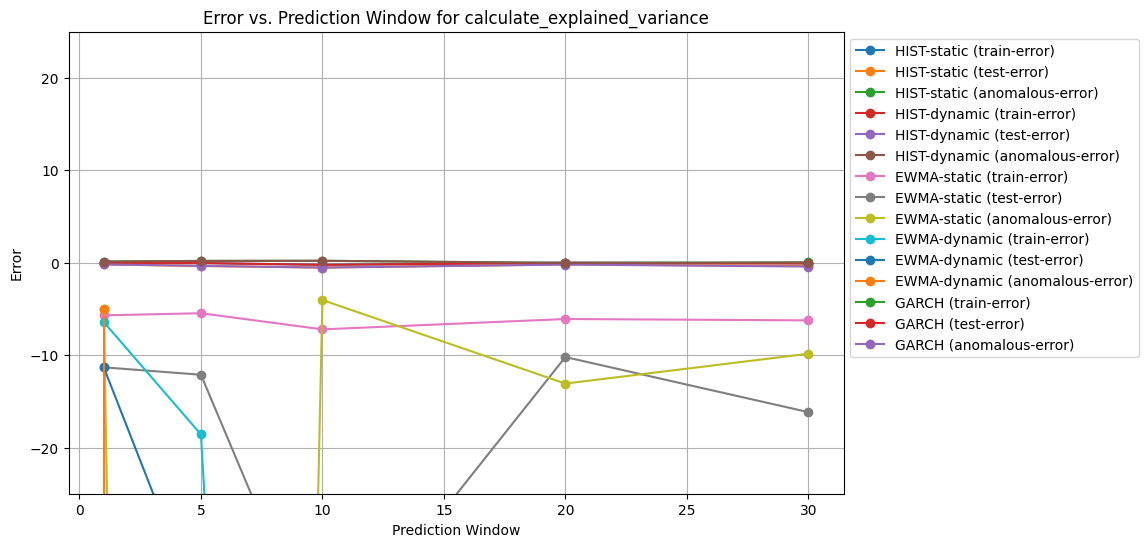

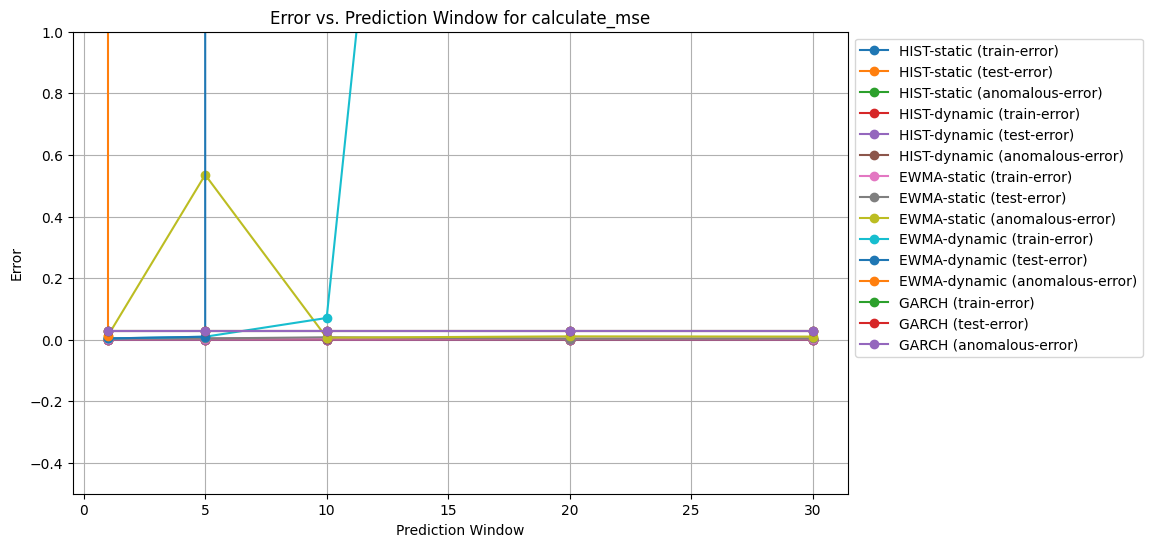

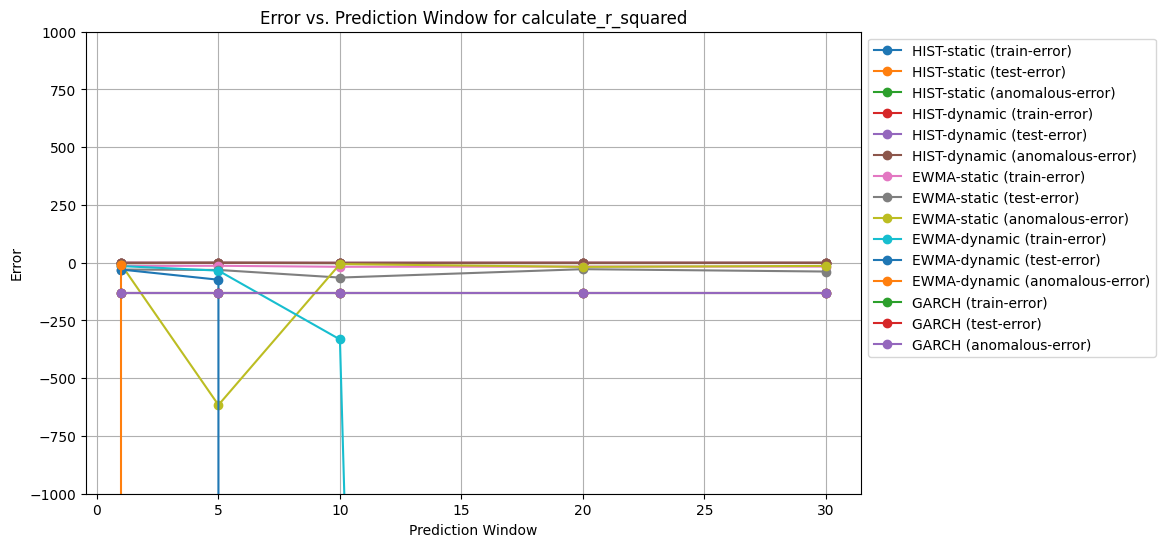

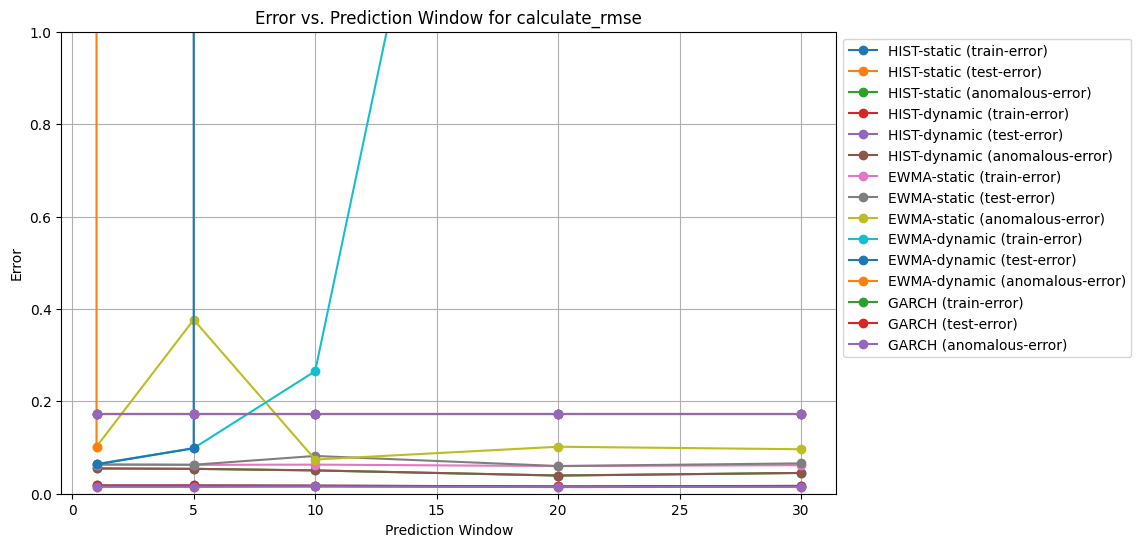

In [ ]:
def plot_error_vs_prediction_window(df, num_std_dev=0.6):
    grouped = df.groupby('Loss Metric')
    windows = [
        [-25, 25],
        [-0.5, 1],
        [-1000, 1000],
        [0, 1]
    ]
    error_types = ['train-error', 'test-error', 'anomalous-error']  # Define the error types

    for (metric, group), window in zip(grouped, windows):
        plt.figure(figsize=(10, 6))

        for model_name in group['Model Name'].unique():
            model_group = group[group['Model Name'] == model_name]

            # Plot each error type
            for error_type in error_types:
                plt.plot(model_group['Prediction Window'], model_group[error_type], label=f'{model_name} ({error_type})', marker='o')

        plt.xlabel('Prediction Window')
        plt.ylabel('Error')
        plt.title(f'Error vs. Prediction Window for {metric}')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(True)

        plt.ylim(window)
        plt.show()
        # plt.savefig(f"{colab_path}/useful_images/{metric}.png")
        # plt.close()

plot_error_vs_prediction_window(acc_df[acc_df['Ticker'] == 'all'])
